# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

<ol type="1"><b>Цель исследования:</b>
    <li>Расчитать рыночную цену недвижимости.</li>
    <li>Определить факторы наиболее влияющие на цену.</li>
</ol>
<ol type="1"><b>Ход исследования:</b>
    <li>Обзор данных.</li>
    <li>Предобработка данных.</li>
    <li>Добавление новых столбцов (цены за кв. м., день недели, месяц и год публикации).</li>
    <li>Изучение отдельных факторов способных влиять на цену недвижимости.</li>
</ol>      

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd

df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

In [2]:
# проверка корректности прочтения датафрейма
df.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [3]:
# сводная информация о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

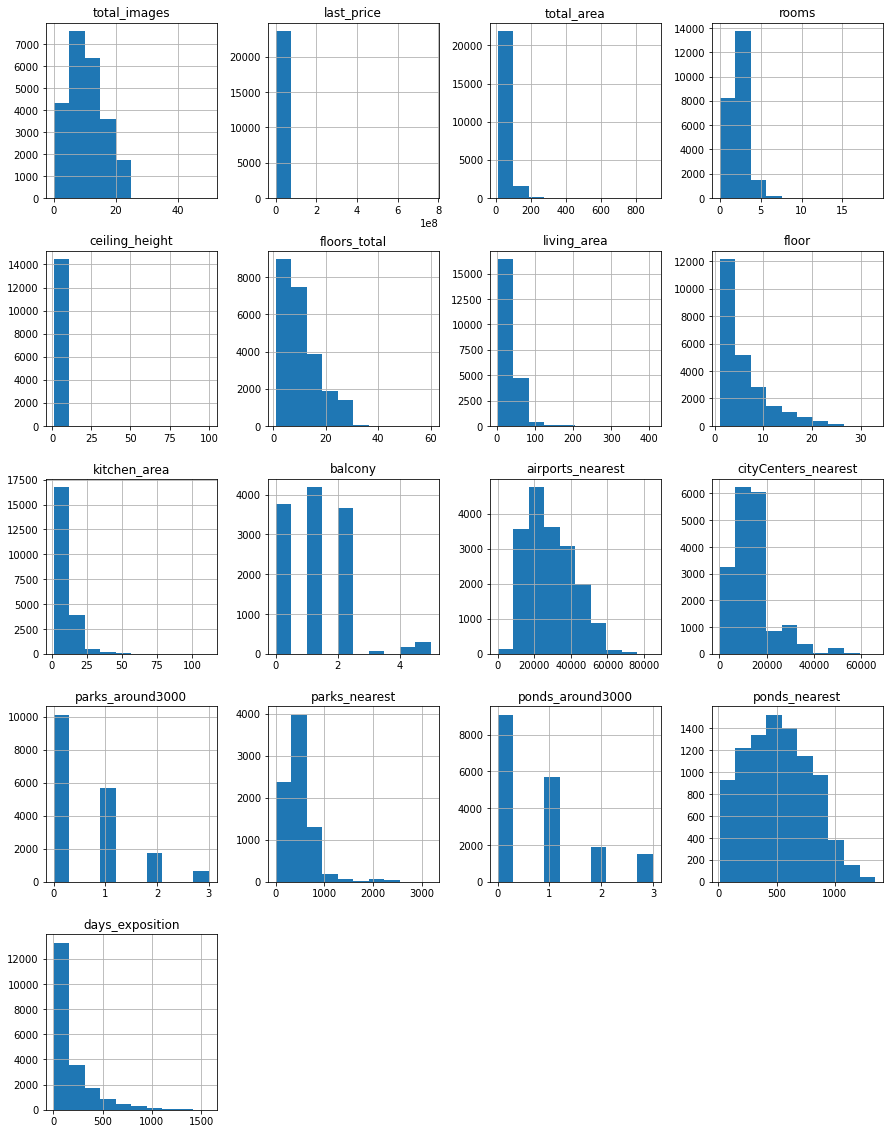

In [4]:
# общая гистограмма для всех столбцов таблицы
df.hist(figsize=(15, 20));

### Предобработка данных

In [5]:
# подсчет пропусков по каждому столбцу
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [6]:
# Проверка на наличие полных дубликатов (совпадение по всем столбцам)
df.duplicated().sum()

0

**Обработка пропусков:**
<ul>
    <li>"ceiling_height" (высота потолков) присутствуют аномально высокие значения более 10 м, вероятно была пропущена запятая     между цифрами;</li>
    <li>"floors_total" (общая этажность объекта) заполнение не представляется возможным, так как в случае заполнения данными из     столбца 'floor' могут быть сильно искажены выводы по объектам на разных этажах ('первый', 'последний' и 'другой');</li>
    <li>"living_area" (жилая площадь) была попытка высчитать размер жилой площади исходя из общей площади объекта, но               выяснилось что суммарно жилая площадь и размер кухни не соответствуют общей площади, а в некоторых случаях даже превышают       её;</li>
    <li>"is_apartment" (является ли объект недвижимости апартаментами) вероятнее всего пропущенные значения можно              интрепретировать как "False";</li>
    <li>"kitchen_area" (размер кухни) заполнение не представляется возможным;</li>
    <li>"balcony" (наличие балкона) вероятнее всего пропущенные значения можно интрепретировать как отсутствие;</li>
    <li>"locality_name" (название населённого пункта) нет данных для заполнения, unknown;</li>
    <li>"airports_nearest" (расстояние до ближайшего аэропорта в метрах) нет данных для заполнения;</li>
    <li>"cityCenters_nearest" (расстояние до центра города) нет данных для заполнения;</li>
    <li>"parks_around3000" (число парков в радиусе 3 км) можно предположить их отсутствие (0);</li>
    <li>"parks_nearest" (расстояние до ближайшего парка ) оставлен без изменения;</li>
    <li>"ponds_around3000" (число водоёмов в радиусе 3 км) можно предположить их отсутствие (0);</li>
    <li>"ponds_nearest" (расстояние до ближайшего водоёма) оставлен без изменения;</li>
    <li>"days_exposition" (сколько дней было размещено объявление (от публикации до снятия)) вероятнее всего предложение действующее и можно заменить на "по настоящее время".</li>
 </ul>

In [7]:
df.fillna({'floors_total': 'unknown', 
           'balcony': 0,
           'locality_name': 'unknown',
           'is_apartment': False, 
           'parks_around3000': 0, 
           'ponds_around3000': 0, 
           'days_exposition': 'по настоящее время'
          }, inplace=True
)

**Для дальнейшей работы с данными столбца `first_day_exposition` необходимо преобразовать тип object в datetime**

In [8]:
# преобразование типа данных в столбце дата публикации
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%d')

**Борьба с неявными дубликатами**

In [9]:
# проверка на корректность наименования населенного пункта (на примере п.г.т. Рябово)
def check_name():
    unique_name = df.locality_name.unique()
    name = []
    for i in range(len(unique_name)):
        try:
            if 'Рябово' in unique_name[i].split():
                name.append(unique_name[i])
        except:
            continue
    return name

In [10]:
# меняем все вхождения буквы ё в наименовании населенного пункта
df['locality_name'].replace('ё+', 'е', regex=True, inplace=True)

In [11]:
# проверка наименования
check_name()

['поселок Рябово', 'поселок городского типа Рябово']

In [12]:
# приведение к единому наименованию
df['locality_name'] = df['locality_name'].str.replace('поселок городского типа', 'поселок')

In [13]:
# проверка
check_name()

['поселок Рябово']

In [14]:
# избавляемся от аномально высоких значений высоты потолков
df.loc[(df.ceiling_height >= 20), 'ceiling_height'] = df.ceiling_height * 0.1

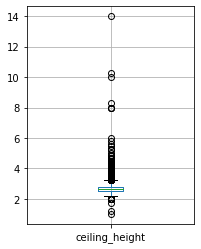

In [15]:
df.boxplot(column=['ceiling_height'], figsize=(3, 4));

In [16]:
# расчитаем границы ящика математически
q1_ch = df.ceiling_height.quantile(0.25)
q3_ch = df.ceiling_height.quantile(0.75)
iqr_ch = q3_ch - q1_ch

In [17]:
filtered_ch = df.query('(@q1_ch - 1.5 * @iqr_ch) <= ceiling_height <= (@q3_ch + 1.5 * @iqr_ch)')

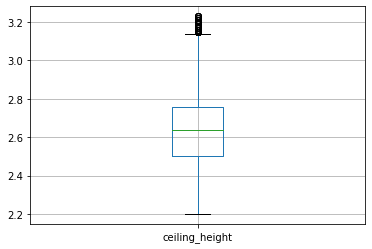

In [18]:
filtered_ch.boxplot(column=['ceiling_height']);

In [19]:
# датафрейм без пропусков высоты потолков
df_ch = df.dropna(subset=['ceiling_height'])

In [20]:
# расчет математических показателей для сравнения двух подходов (box_method, decimal_part)]]:

# общее кол-во строк 'full'
box_method_full = filtered_ch.shape[0]
decimal_part_full = df_ch.shape[0]

# медианное значение 'median'
box_method_median = filtered_ch.ceiling_height.median()
decimal_part_median = df_ch.ceiling_height.median()

# минимальное значение 'min'
boxplot_method_min = filtered_ch.ceiling_height.min()
decimal_part_min = df_ch.ceiling_height.min()

# максимальное значение 'max'
boxplot_method_max = filtered_ch.ceiling_height.max()
decimal_part_max = df_ch.ceiling_height.max()

In [21]:
# сводная таблица показателей двух подходов
d = {'full': [box_method_full, decimal_part_full],
     'median': [box_method_median, decimal_part_median],
     'min': [boxplot_method_min, decimal_part_min],
     'max': [boxplot_method_max, decimal_part_max]
}
table = pd.DataFrame(
    data = d,
    index=['boxplot_method', 'decimal_part_method']              
)

table

,full,median,min,max
boxplot_method,13704,2.64,2.2,3.23
decimal_part_method,14504,2.65,1.0,14.00


<b>Вывод:</b> Применение подхода по очистке данных от выбросов с помощью "ящика с усами" (boxplot_method) ведет к незначительной потере данных (14504 VS 13704). Недостаток подхода основанного на предположении пропуска десятичной дроби (decimal_part_method) заключается в сохранении аномальных значений (минимум 1 метр (видимо для хоббитов) и максимум - 14 метров (что допустимо если речь идет о коммерческой недвижимости)). При этом можно утверждать о том, что медианное значение остается неизменным (2.65 метра).
 

In [22]:
# изменение типов данных
df = df.astype({'balcony': 'int', 
                'parks_around3000': 'int', 
                'ponds_around3000': 'int',
                'last_price': 'int'
                }
)    

### Посчитайте и добавьте в таблицу новые столбцы

In [23]:
# добавляем столбец цены одного кв. м. объекта недвижимости (тип Integer)
df['price_per_sq_metr'] = (df['last_price'] / df['total_area']).astype('int')

In [24]:
# добавляем столбец с днями недели даты публикации (0 — понедельник, 1 — вторник и т.д.)
df['day_of_week'] = df.first_day_exposition.dt.dayofweek

# столбец месяца публикации объявления
df['month'] = df.first_day_exposition.dt.month

# столбец года публикации объявления
df['year'] = df.first_day_exposition.dt.year

In [25]:
# столбец со связкой год-месяц
df['year_month'] = df['first_day_exposition'].dt.to_period("M")

In [26]:
# типизация объектов недвижимости по этажу ('первый', 'последний', 'другой')
def floor_type(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'

df['floor_type'] = df.apply(floor_type, axis=1)

In [27]:
# перевод метров в километры и округление до целых значений
df['cityCenters_nearest'] = round(df['cityCenters_nearest'] / 1000, 0)

### Проведите исследовательский анализ данных

#### Изучение следующих параметров объектов:

**Общая площадь** `total_area`

<AxesSubplot:title={'center':'total area'}, ylabel='Frequency'>

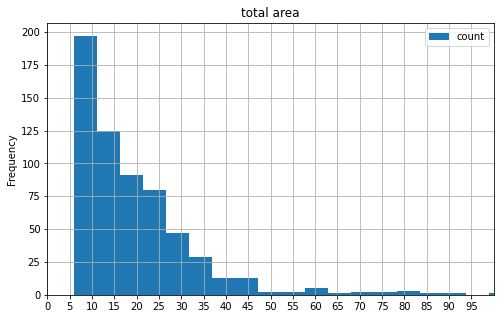

In [28]:
df.pivot_table(index='total_area', values='total_images', aggfunc='count') \
  .reset_index().sort_values('total_images', ascending=False) \
  .rename(columns={'total_images': 'count'}).query('count > 5') \
  .plot(kind='hist', bins=80, y='count', grid=True, figsize=(8, 5), 
        title='total area', xlim=(0, 100), xticks=range(0, 100, 5))

In [29]:
# top-15 по кол-ву предложений по ообщей площади
df.value_counts('total_area', ascending=False).reset_index()[:15].sort_values('total_area')

,total_area,0
3,31.0,346
7,32.0,289
11,35.0,262
9,36.0,280
12,38.0,237
5,40.0,315
14,41.0,227
1,42.0,383
6,43.0,301
4,44.0,345


***Вывод: Объекты с общей площадью от 31 до 60 квадратных метров имеют самое высокое предложение на рынке. Наиболее популярна недвижимость общей площадью 45 кв. м.***

**Жилая площаль** `living_area`

In [30]:
# избавляемся от пропусков
df_living_area = df.dropna(axis=0, how='any', subset=['living_area'])

<AxesSubplot:title={'center':'living area'}, ylabel='Frequency'>

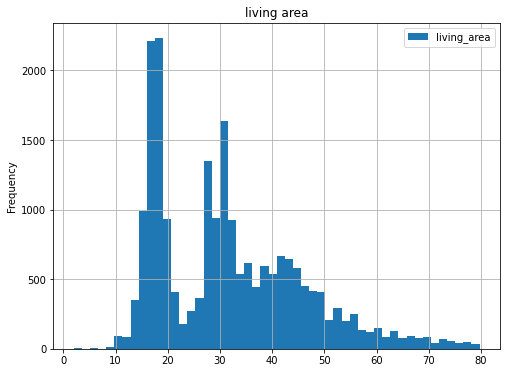

In [31]:
df_living_area.query('living_area < 80').plot(kind='hist', 
                                              bins=50, 
                                              figsize=(8, 6), 
                                              y='living_area', 
                                              grid=True, 
                                              title='living area'                                  
)

In [32]:
# top-15 предложений по жилой площади
df_living_area.value_counts('living_area', ascending=False).reset_index()[:15].sort_values('living_area')

,living_area,0
10,15.0,313
3,16.0,486
1,17.0,675
0,18.0,882
7,19.0,329
4,20.0,481
11,27.0,311
5,28.0,423
9,29.0,319
2,30.0,598


***Вывод: Объекты с жилой площадью от 15 до 43 квадратных метров имеют самое высокое предложение на рынке. Наиболее популярна недвижимость с размерами 17, 18 и 30 кв. м.***

**Площадь кухни** `kitchen_area`

In [33]:
# избавляемся от пропусков
df_kitchen_area = df.dropna(axis=0, how='any', subset=['kitchen_area'])

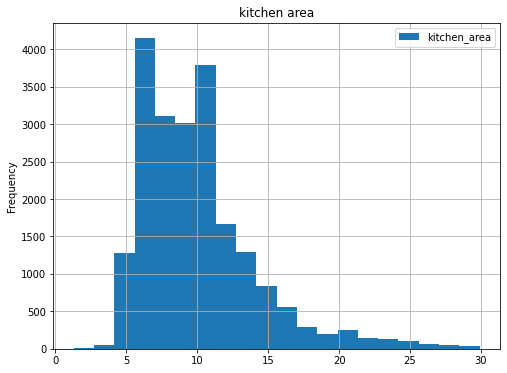

In [34]:
df_kitchen_area.query('kitchen_area < 30').plot(
                                              kind='hist', 
                                              bins=20, 
                                              figsize=(8, 6), 
                                              y='kitchen_area',
                                              grid=True, 
                                              title='kitchen area', 
                                              xlabel='kitchen area'
);                                  

In [35]:
# top-5 предложений по площади кухни
df_kitchen_area.value_counts('kitchen_area', ascending=False).reset_index()[:5].sort_values('kitchen_area')

,kitchen_area,0
0,6.0,1300
4,7.0,1062
2,8.0,1110
3,9.0,1101
1,10.0,1262


***Вывод: Недвижимость с размерми кухни от 6 до 10 кв.м. имеют самое высокое предложение.***

**Цена объекта** `last_price`

##### Посмотрим минимальную цену

In [36]:
min_price = df.last_price.min()
df.query('last_price == @min_price')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_sq_metr,day_of_week,month,year,year_month,floor_type
8793,7,12190,109.0,2019-03-20,2,2.75,25.0,32.0,25,False,...,805.0,0,NaN,8.0,111,2,3,2019,2019-03,последний


In [37]:
# средняя цена объекта от 100 до 110 кв.м. в г. Санкт-Петербург
df.query('total_area > 100 & total_area < 110 & locality_name == "Санкт-Петербург"')['last_price'].mean().round(2)

13553205.56

Цена объекта недвижимости общей площадью более 100 кв.м., состоящего из 7-ми комнат, находящегося в Санкт_Петербурге не соответствует реальной. Предположение о том, что стоимость указана в иностранной валюте (USD/EUR) не выдерживает проверки по причине очень низкой цены:
<ul>
    <li>65.15 (USD) - 800 тыс.</li> 
    <li>73.75 (EUR) - 900 тыс.</li>
</ul>
При средней цене схожих объектов более 13,5 млн. руб.

In [38]:
# избавимся от аномальной цены
df_price = df.query('last_price != @min_price')

In [39]:
# расчитаем пределы ящика с усами
q1 = df_price.last_price.quantile(0.25)
q3 = df_price.last_price.quantile(0.75)
iqr = q3 - q1

In [40]:
filtered = df_price.query('(@q1 - 1.5 * @iqr) <= last_price <= (@q3 + 1.5 * @iqr)')

<AxesSubplot:title={'center':'price'}, ylabel='Frequency'>

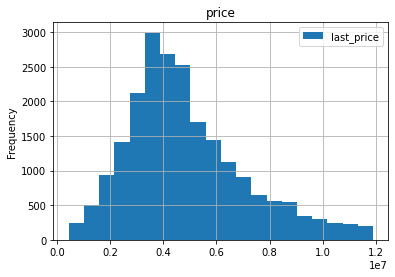

In [41]:
filtered.plot(kind='hist', y='last_price', grid=True, bins=20, title='price')

In [42]:
# топ-20 объявлений по цене
top_20_for_price = filtered.value_counts('last_price').reset_index()[:20].sort_values(by='last_price')
top_20_for_price

,last_price,0
14,3100000,220
8,3200000,238
6,3300000,244
11,3400000,227
1,3500000,291
5,3600000,257
9,3700000,234
7,3800000,240
13,3900000,221
3,4000000,260


In [43]:
# процент объявлений из первой 20-ки от общего числа предложений
round(
    top_20_for_price.sum()[0] / filtered.shape[0] * 100, 2
)

22.0

***Вывод: Больше всего предложений по цене от 3,1 до 5,5 млн. руб. что составляет 22% от общего числа объявлений.***

**Количество комнат** `rooms`

<AxesSubplot:title={'center':'rooms'}, ylabel='Frequency'>

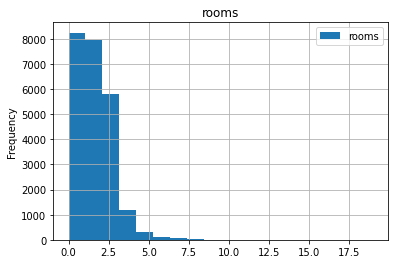

In [44]:
df.plot(kind='hist',
        y='rooms',
        title='rooms',
        grid=True,
        bins=18
)

In [45]:
# топ-3 предложений по кол-ву комнат
df.value_counts('rooms')[:3].to_frame().reset_index()

,rooms,0
0,1,8047
1,2,7940
2,3,5814


In [46]:
# процент одно и двухкомнатных предложений от общего числа объявлений
round(
    df.value_counts('rooms')[:2].sum() / df.shape[0] * 100, 2
)

67.46

***Вывод: Чаще всего на продажу выставляются кватриры с одной или двумя комнатами. Общее их предложение составляет 67,5%.***

**Высота потолков** `ceiling_height`

<AxesSubplot:title={'center':'celing height'}, ylabel='Frequency'>

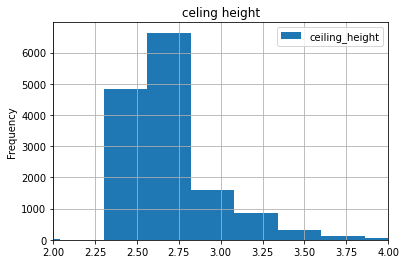

In [47]:
df.plot(kind='hist',
        y='ceiling_height',
        xlim=(2, 4),
        bins=50,
        title='celing height',
        grid=True
)

In [48]:
# топ-7 предложений по высоте потолков
df.value_counts('ceiling_height', ascending=False).reset_index()[:7].sort_values('ceiling_height')

,ceiling_height,0
0,2.50,3522
5,2.55,980
1,2.60,1647
2,2.70,1582
6,2.75,911
4,2.80,993
3,3.00,1112


In [49]:
# процент топ-7 по высоте потолков от общего числа объявлений
round(
    df.value_counts('ceiling_height', ascending=False)
      .reset_index()[:7].sort_values('ceiling_height').sum()[0] / df.shape[0] * 100, 2
)

45.35

***Вывод: Наиболее распространены предложения недвижимости с высотой потолков от 2,5 до 3 метров. Их доля составляет более 45% от общего числа объявлений.***

**Этаж квартиры** `floor`

In [50]:
df.value_counts('floor')[:10].reset_index().sort_values('floor')

,floor,0
2,1,2917
0,2,3368
1,3,3073
3,4,2804
4,5,2621
5,6,1305
6,7,1218
7,8,1083
8,9,1051
9,10,687


In [51]:
# процент объявлений с 1-го по 10-ый этаж
round(
    df.value_counts('floor')[:10].reset_index().sort_values('floor')[0].sum() 
    / df.shape[0] * 100, 2
)

84.93

<AxesSubplot:title={'center':'floor'}, ylabel='Frequency'>

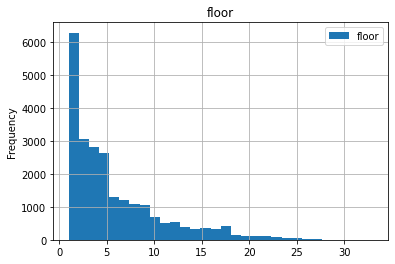

In [52]:
df.plot(kind='hist',
        bins=30,
        y='floor',
        title='floor',
        grid=True
)

***Вывод: Общее количество предложений от 1 до 10 этажа насчитывают 20127 единиц что составляет почти 85%. Больше всего объявлений о продаже квартир расположенных на 2-ом этаже.*** 

**Тип этажа квартиры** `floor_type`

In [53]:
# Распределение количества объявлений по типу этажа
df.value_counts('floor_type', normalize=True).mul(100).round(2).to_frame().reset_index()

,floor_type,0
0,другой,73.61
1,последний,14.08
2,первый,12.31


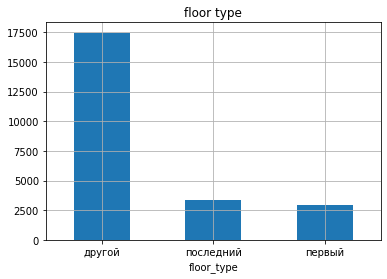

In [54]:
df.value_counts('floor_type').plot.bar(rot=0, title='floor type', grid=True);

***Вывод: Среди объявлений подавляющее большинство составляют квартиры расположенные ни на первом ни на последнем этаже.***

**Общее количество этажей в доме** `floors_total`

In [55]:
# топ-7 предложений по общему кол-ву этажей
df.value_counts('floors_total').reset_index()[:7]

,floors_total,0
0,5.0,5788
1,9.0,3761
2,16.0,1376
3,12.0,1362
4,4.0,1200
5,10.0,1174
6,25.0,1075


<AxesSubplot:ylabel='Frequency'>

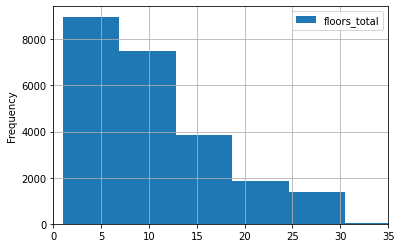

In [56]:
df.query('floors_total != "unknown"').plot(kind='hist', y='floors_total', xlim=(0, 35), grid=True)

***Вывод: Чаще всего на продажу выставляются квартиры в 5-ти (наибольшее кол-во) и 9-ти этажных домах.***

**Расстояние до центра города в метрах** `cityCenters_nearest`

<AxesSubplot:title={'center':'distance to the center'}, ylabel='Frequency'>

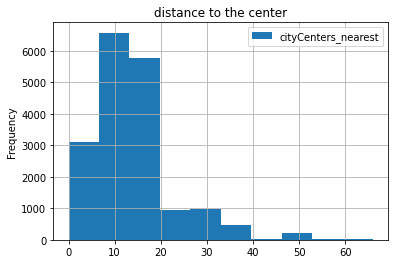

In [57]:
df.plot(kind='hist', y='cityCenters_nearest', grid=True, title='distance to the center')

In [58]:
# топ-10 по расстоянию до центра города
df.value_counts('cityCenters_nearest')[:10].to_frame()

,0
cityCenters_nearest,
12.0,1607
15.0,1568
13.0,1457
14.0,1279
16.0,1265
11.0,1179
5.0,924
17.0,919
10.0,721


***Вывод: Чаще всего продаются квартиры с удаленностью от центра города от 11-ти до 16-ти километров.***

**Расстояние до ближайшего аэропорта** `airports_nearest` 

In [59]:
# пересчитаем количество метров в километры
df['airports_nearest'] = round(df['airports_nearest'] / 1000)

<AxesSubplot:title={'center':'distance to the airport'}, ylabel='Frequency'>

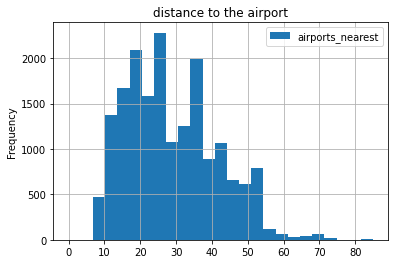

In [60]:
df.plot(
    kind='hist', y='airports_nearest', grid=True, title='distance to the airport', bins=25, xticks=range(0, 90, 10)
)

In [61]:
df.value_counts('airports_nearest').reset_index()[:10].sort_values('airports_nearest')

,airports_nearest,0
8,13.0,546
4,14.0,594
5,15.0,584
7,18.0,572
3,19.0,625
2,22.0,626
1,24.0,631
0,25.0,633
9,36.0,544
6,37.0,579


***Вывод: Лидерами по количеству объявлений являются объекты расположенные на расстоянии от 19 до 25 км до ближайшего аэропорта.*** 

**Расстояние до ближайшего парка** `parks_nearest`

In [62]:
# пересчитаем количество метров в километры
df['parks_nearest'] = round(df['parks_nearest'] / 1000)

<AxesSubplot:title={'center':'distance to the park'}, ylabel='Frequency'>

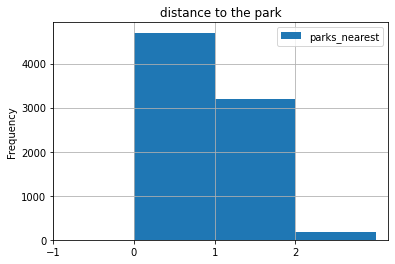

In [63]:
df.plot(kind='hist', y='parks_nearest', grid=True, title='distance to the park', bins=3, xticks=range(-1, 3))

In [64]:
df.value_counts('parks_nearest', normalize=True).mul(100).round(2).to_frame()

,0
parks_nearest,
0.0,58.18
1.0,39.67
2.0,1.96
3.0,0.20


***Вывод: В 58% объявлений ближайший парк находится в шаговой доступности (менее 1 км), в пределах 2-км - 40% предложений.***

**День и месяц публикации объявления** `day_of_week` и	`month`

In [65]:
# Распределение по годам
df.value_counts('year', normalize=True).mul(100).reset_index().sort_values('year')

,year,0
5,2014,0.578083
4,2015,5.025529
3,2016,11.743112
1,2017,34.558420
0,2018,35.946664
2,2019,12.148192


In [66]:
# тепловая карта кол-ва предложений по месяцам (индексы от 1 до 12) и дням недели (колонки от 0 до 6)
df.pivot_table(index='month', columns='day_of_week', values='total_images', aggfunc='count') \
  .reset_index().style.background_gradient(cmap='Reds')

day_of_week,month,0,1,2,3,4,5,6
0,1,285,233,264,208,254,135,121
1,2,350,456,372,771,349,173,169
2,3,396,491,401,417,432,248,202
3,4,451,409,329,414,423,183,170
4,5,172,211,272,250,225,77,67
5,6,202,286,281,372,345,157,117
6,7,318,345,265,246,220,165,136
7,8,262,336,353,289,269,131,104
8,9,260,353,400,314,313,181,160
9,10,371,404,365,311,382,152,142


***Вывод: Более 70% всех объявлений были опубликованы в 2017 и 2018 годах. Больше всего объявлений было опубликовано в начале года с февраля по апрель. Пик пришелся на четверг февраля - почти в 2 раза больше обычного среднего количества. При этом прослеживается динамику среди дней недели: наибольшая активность в будни и спад в выходные. Январь, май, июнь и декабрь являются наименее активными месяцами.*** 

#### Изучение, как быстро продавались квартиры (столбец `days_exposition`)

In [67]:
# расчет среднего и медианного значения
df.query('days_exposition != "по настоящее время"').agg({'days_exposition': ['mean', 'median']}).round()

,days_exposition
mean,181.0
median,95.0


In [68]:
df_days_exposition = df.query('days_exposition != "по настоящее время"')

In [69]:
days_median = df_days_exposition.days_exposition.median()

<AxesSubplot:ylabel='Frequency'>

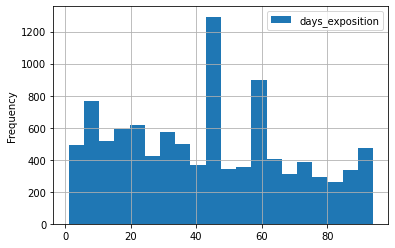

In [70]:
df_days_exposition.query('days_exposition < @days_median').plot(kind='hist', y='days_exposition', bins=20, grid=True)

<AxesSubplot:ylabel='Frequency'>

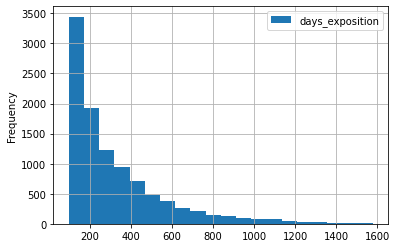

In [71]:
df_days_exposition.query('days_exposition > @days_median').plot(kind='hist', y='days_exposition', bins=20, grid=True)

In [72]:
# 25% квантиль
df_days_exposition['days_exposition'].quantile(0.25)

45.00000000000001

In [73]:
# 75% квантиль
df_days_exposition['days_exposition'].quantile(0.75)

232.0

***Вывод: В среднем продажа недвижимости занимает полгода. Быстрыми продажами можно считать сделки со сроком менее полутора месяцев (25% квантиль). Все сделки сроком более семи с половиной месяцев (75% квантиль) можно считать долгими.***


#### Зависимость цены объекта `last_price` от следующих параметров: 
<ul>
    <li>last_price
    <li>total_area 
    <li>living_area 
    <li>kitchen_area 
    <li>rooms
    <li>floor_type 
    <li>day_of_week 
    <li>month 
    <li>year
</ul>    

In [74]:
# расчет коэффициентов корреляции 
df[['last_price', 'total_area', 'living_area', 'kitchen_area', 
    'rooms', 'floor_type', 'day_of_week', 'month', 'year']].corr()['last_price'].to_frame()

,last_price
last_price,1.000000
total_area,0.653675
living_area,0.566492
kitchen_area,0.519869
rooms,0.363343
day_of_week,0.001550
month,0.002779
year,-0.043089


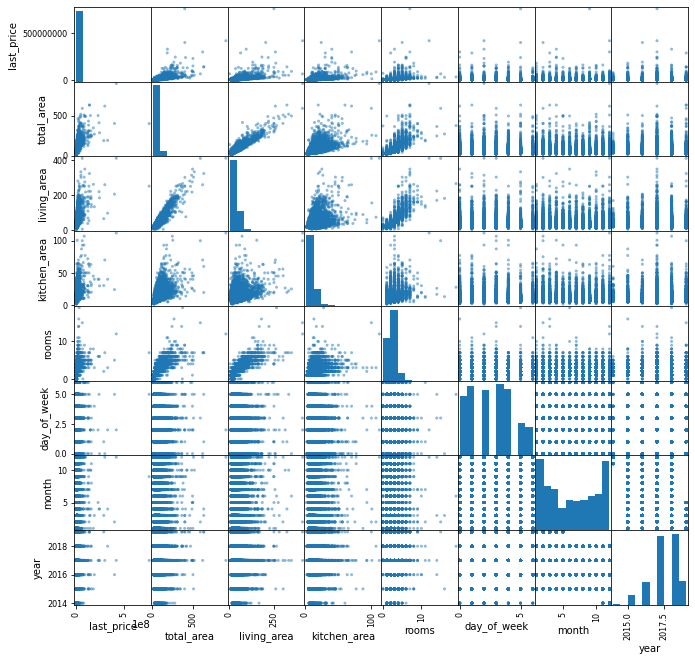

In [75]:
# Построим матрицу рассеяния для отдельных столбцов
pd.plotting.scatter_matrix(
                df[['last_price', 'total_area', 'living_area', 
                    'kitchen_area', 'rooms', 'floor_type',
                    'day_of_week', 'month', 'year']], 
                    figsize=(11, 11)
);

***Вывод: При оценке можно говорить о наибольшей взаимосвязи (коэфф. корр. средний 0.65) цены `last_price` от общей площади объекта недвижимости `total_area`. Также можно говорить о средней корреляции жилой пллощади `living_area` (0.57) и площади кухни `kitchen_area` (0.52), а также о слабой корреляции с количеством комнат `rooms` (0.36).***

#### Расчет средней цены одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений

In [76]:
# топ-10 населенных пунктов по количеству предложений
top10_proposal = df.value_counts('locality_name')[:10].to_frame().index.to_list()
top10_proposal

['Санкт-Петербург',
 'поселок Мурино',
 'поселок Шушары',
 'Всеволожск',
 'Пушкин',
 'Колпино',
 'поселок Парголово',
 'Гатчина',
 'деревня Кудрово',
 'Выборг']

In [77]:
# фильтруем датафрейм
df_top10 = df.query('locality_name in @top10_proposal')

In [78]:
# меданная цена квадратного метра
df_top10.groupby('locality_name') \
        .agg({'price_per_sq_metr': 'median'}) \
        .reset_index() \
        .rename(columns={'price_per_sq_metr': 'median_price'}) \
        .sort_values('median_price', ascending=False).round()

,locality_name,median_price
5,Санкт-Петербург,104761.0
4,Пушкин,100000.0
6,деревня Кудрово,91860.0
8,поселок Парголово,91642.0
7,поселок Мурино,85878.0
9,поселок Шушары,76876.0
3,Колпино,74724.0
2,Гатчина,67796.0
0,Всеволожск,65789.0
1,Выборг,58158.0


***Вывод: Медианная цена квадратного метра в Санкт-Петербурге является самой высокой среди населенных пунктов с наибольшим количеством предложений и составляет приблизительно 105 тыс. руб. Наименьшая средняя цена наблюдается в г. Выборге, 58 тыс. руб.***

#### Взаимосвязь стоимости объектов от расстояния до центра города

In [79]:
# фильтрует датафрейм по населенному пункту (СПб) и избавляемся от пропусков
df_spb = df.query('locality_name == "Санкт-Петербург" & cityCenters_nearest != 0 & last_price != @min_price') \
           .dropna(subset=['cityCenters_nearest'])

In [80]:
# добавляем столбец со стоимостью одного километра
df_spb['price_per_km'] = df_spb['last_price'] / df_spb['cityCenters_nearest']

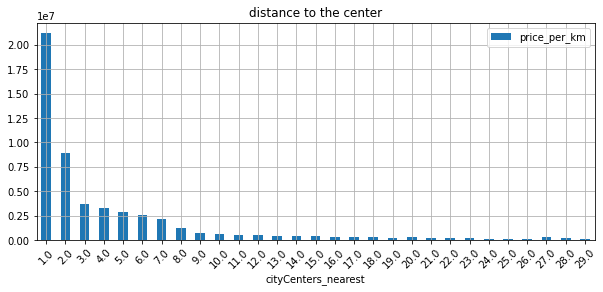

In [81]:
# средняя цена километра до центра города
df_spb.groupby('cityCenters_nearest') \
      .agg({'price_per_km': 'mean'}).reset_index() \
      .plot.bar(x='cityCenters_nearest', rot=45, grid=True, title='distance to the center', figsize=(10, 4));

In [82]:
# корреляция цены с расстоянием до центра
df_spb['last_price'].corr(df_spb['price_per_km']).round(3)

0.758

In [83]:
# сводная таблица по средней стоимости 1 км (млн. руб.) 
df_spb.groupby('cityCenters_nearest') \
      .agg({'price_per_km': 'mean'}).mul(0.1 ** 6) \
      .pivot_table(columns='cityCenters_nearest')

cityCenters_nearest,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0
price_per_km,21.206721,8.89416,3.70886,3.32607,2.899824,2.556403,2.110736,1.244715,0.773598,0.650412,...,0.297573,0.261594,0.24616,0.216755,0.160601,0.162114,0.152808,0.307407,0.179515,0.146092


<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №2__

Да, всё верно =)
</div>

***Вывод: Существует взаимосвязь между стоимостью объекта недвижимости и расстоянием до центра города. Об этом свидетельствует высокая корреляция (0.76). Самыми дорогими являются объекты в пределах одного километра от центра.***

### Общий вывод

***Вывод: Данные представлены предложением объектов недвижимости находящихся преимущественно в Санкт-Петербурге - 66% всех публикаций, опубликованные в период с 2014 по 2019 год включительно. Это преимущественно квартиры с одной или двумя комнатами, общей площадью 45 кв. м. Чаще всего это объекты расположенные на 2-ом этаже в 5-ти или 9-тиэтажных домах. Средняя цена в Санкт-Петербурге составляет 115 тыс. руб. за квадратный метр и наиболее коррелирует с общей площадью (0.65) и расстоянием до центра города (0.76).***


<ol><b>Вывод:</b> 
    <li>Был исследован архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет (2014 -2019).</li>
    <li>Проведена предобработка данных в ходе которой были устранены неявные дубликаты, установлены и устранены аномалии в данных, что существенно повысило точность расчетов.</li> 
    <li>Были добавлены дополнительные параметры такие как: цена за м2 (`price_per_sq_metr`), день (`day_of_week`), месяц (`month`) и год (`year`) публикации.</li>
    <li>Математически определены сроки сделок: средней продолжительности, "быстрых" и необычно долгих.</li>
    <li>Найдены факторы наибольшего влияния на цену недвижимости: общая площадь и расстояние до центра.</li>
    <li>Для населенных пунктов с наибольшим числом объявлений (топ-10) дополнительно расчитана средняя стоимость м2.</li>
</ol>   

In [84]:
# Сводная таблица результатов исследования
d = ['', 45, 115,
     '', 'меньше 45', '180', 'больше 230',
     '', '0.76', '0.65', '0.57', '0.52'
]

idx = ['Общая информация', 'Предложения в СПб, %', 'Средняя цена за м2, тыс. руб.',
     'Сроки сделки', 'Быстрая, дней', 'Средняя, дней', 'Долгая, дней',
     'Взаимосвязь (корреляция)', 'Расстояние до центра города', 'Общая площадь', 'Жилая площадь', 'Площадь кухни'   
]

table = pd.DataFrame(data=d, index=idx, columns=[''])

format_table = table.style.set_table_styles([{"selector":"th.row_heading", "props": [('text-align', 'left')]},])
format_table

,
Общая информация,
"Предложения в СПб, %",45
"Средняя цена за м2, тыс. руб.",115
Сроки сделки,
"Быстрая, дней",меньше 45
"Средняя, дней",180
"Долгая, дней",больше 230
Взаимосвязь (корреляция),
Расстояние до центра города,0.76
Общая площадь,0.65
